In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import pandas_gbq
from google.oauth2 import service_account
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

In [2]:
credentials = service_account.Credentials.from_service_account_file('astute-asset-303615-e74359398775.json')
pandas_gbq.context.credentials = credentials
pandas_gbq.context.progect = "astute-asset-303615"

## Описательная статистика

### 1. Динамика по датам

#### 1) ARPU, ARPPU, CR

In [3]:
sql81 ="""
SELECT
    date,
    
--  COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId)) AS sum_clients,
--  SUM(IF(transactions > 0, 1, 0)) AS paid_clients,
    
    ROUND(SUM(revenue) / COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId)), 2) AS ARPU,
    ROUND(SUM(revenue) / SUM(IF(transactions > 0, 1, 0)), 2) AS ARPPU,
    ROUND(SUM(transactions) / COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId)), 3)*100 AS CR 

  FROM `astute-asset-303615.Project_3.ga_data`
    
  GROUP BY date
"""

df81=pandas_gbq.read_gbq(sql81, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 1097.84rows/s]


In [113]:
df81 = df81.sort_values('date')

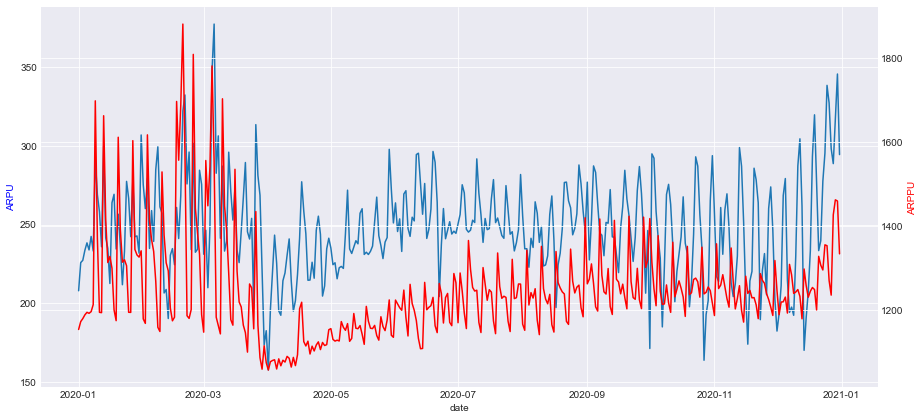

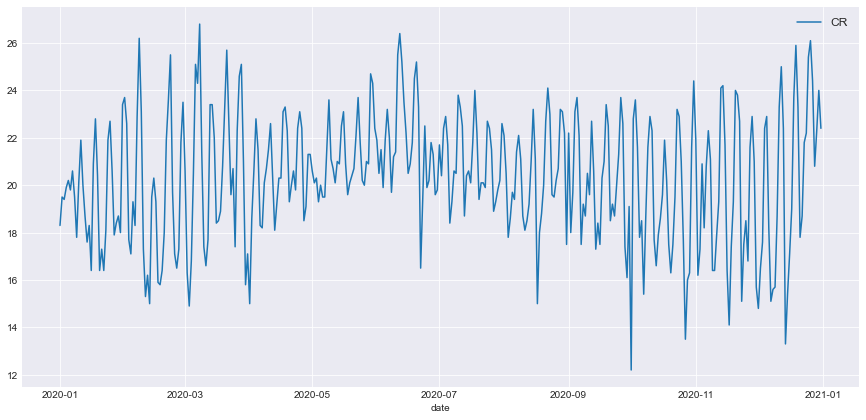

In [199]:
x = df81['date']
y1 = df81['ARPU']
y2 = df81['ARPPU']

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
ax.plot(x,y1, label='ARPU')
ax2 = ax.twinx()
ax2.plot(x,y2, '-r', label='ARPPU')
ax.set_xlabel('date')
ax.set_ylabel('ARPU', color = 'b')
ax2.set_ylabel(r'ARPPU', color = 'r')

y3 = df81['CR']
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
ax.plot(x,y3, label='CR')
ax.set_xlabel('date')
plt.legend(fontsize=12)
plt.show()

##### В начале апреля сильно падает ARPPU, возможно это связано с введением самоизоляции. Конверсия при этом не падает, а даже растет в этот период. Также наблюдается рост всех показателей в середине декабря

#####  Проверим гипотезу с самоизоляцией - нарисуем графики распределений до 1 апреля и после

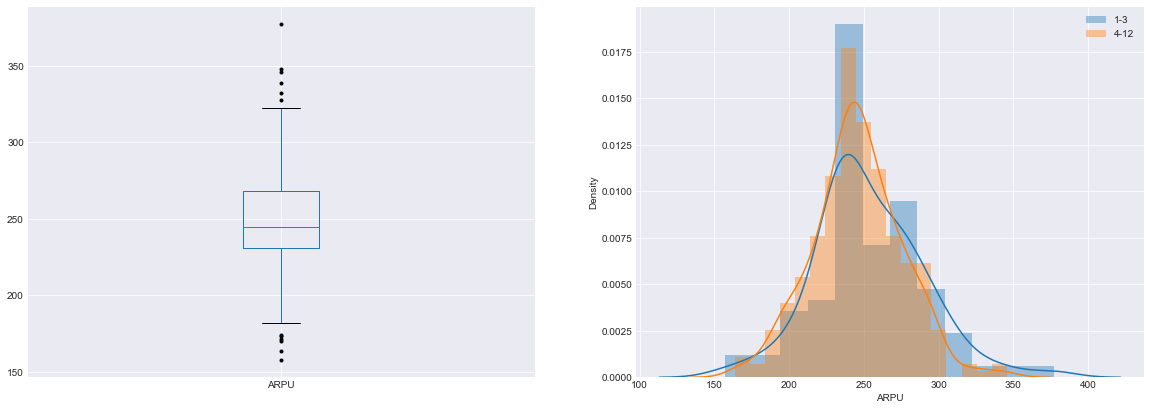

In [4]:
# ARPU
plt.figure(figsize = (20, 15))
plt.subplot(2, 2, 1)
df81_box1 = pd.DataFrame(df81['ARPU'])
df81_box1.boxplot(sym='k.')

plt.subplot(2, 2, 2)
sns.distplot(df81[df81['date']<='2020-04-01'].sort_values('ARPU')['ARPU'], label = '1-3')
sns.distplot(df81[df81['date']>'2020-04-01'].sort_values('ARPU')['ARPU'], label = '4-12')
plt.legend()
plt.show()

##### После апреля распределение меняется не сильно

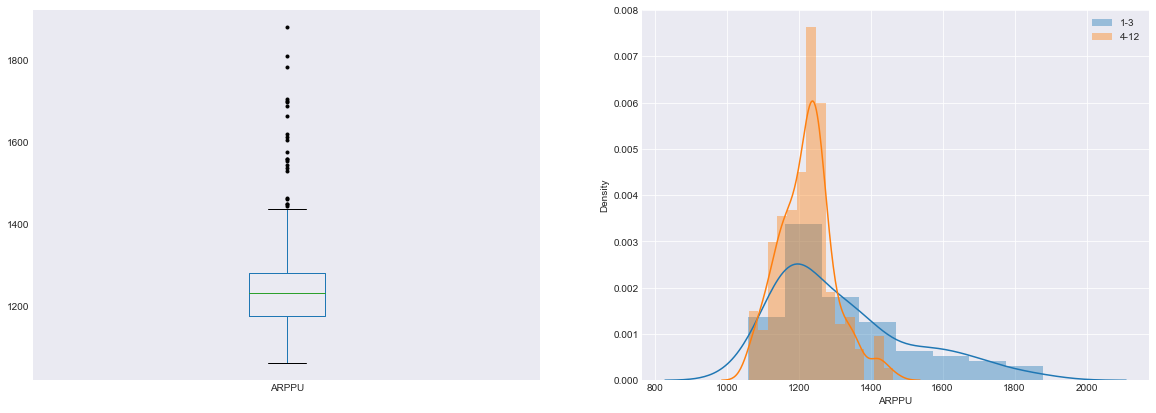

In [323]:
# ARPPU
plt.figure(figsize = (20, 15))
plt.subplot(2, 2, 1)
df81_box2 = pd.DataFrame(df81['ARPPU'])
df81_box2.boxplot(sym='k.') 
plt.grid(False)

plt.subplot(2, 2, 2)
sns.distplot(df81[df81['date']<='2020-04-01'].sort_values('ARPPU')['ARPPU'], label = '1-3')
sns.distplot(df81[df81['date']>'2020-04-01'].sort_values('ARPPU')['ARPPU'], label = '4-12')
plt.legend()
plt.show()

##### Для ARPPU в распределении наблюдался длинный хвост справа, который исчез после апреля - распределение становится узким. Возможно, уменьшилось количество больших заказов, типа корпоративных обедов или заказов по выходным (максимумы arppu приходились соответвствовали пятнице или выходным)

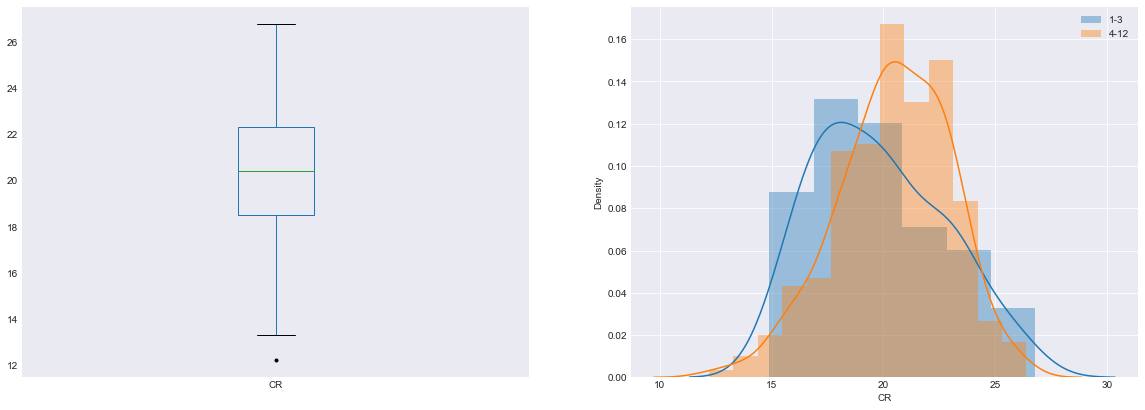

In [324]:
# CR
plt.figure(figsize = (20, 15))
plt.subplot(2, 2, 1)
df81_box3 = pd.DataFrame(df81['CR'])
df81_box3.boxplot(sym='k.') 
plt.grid(False)

plt.subplot(2, 2, 2)
sns.distplot(df81[df81['date']<='2020-04-01'].sort_values('CR')['CR'], label = '1-3')
sns.distplot(df81[df81['date']>'2020-04-01'].sort_values('CR')['CR'], label = '4-12')
plt.legend()
plt.show()

##### Распределение конверсии широкое, выбросов почти нет. После апреля видим, что среднее значение увеличивается - возможно из-за того, что пользователи стали чаще заказывать еду на дом

#### 2) CPA, ROI

In [353]:
sql82 ="""
SELECT
  date,
  ROUND((rev-spend)/spend,2)*100 AS ROI,
  ROUND(spend/sum_transactions,2) AS CPA,
  spend AS spend
  
FROM 

-- Сбор дохода по дням для источников, у которых есть спенд
(SELECT
    date,
    SUM(revenue) AS rev,
    SUM(transactions) AS sum_transactions
  FROM `astute-asset-303615.Project_3.ga_data`
  WHERE
       source = 'yandex'  AND medium = 'cpc'
    OR source = 'google'  AND medium = 'cpc'
    OR source = 'admitad' AND medium = 'cpa'
    
  GROUP BY date) ga
    
JOIN 

-- Сбор суммарного расхода по дням

 (SELECT date, SUM(cost) AS spend
      FROM 
      
      -- Сбор расходов из 3 таблиц
      
          (SELECT cost, date
           FROM `astute-asset-303615.Project_3.admitad_data` 
           
           UNION ALL
           
           SELECT cost, date
           FROM `astute-asset-303615.Project_3.g_ads_data`
           
           UNION ALL
           
           SELECT cost, date
           FROM `astute-asset-303615.Project_3.ya_direct_data`) costs
        
        GROUP BY date) costun
       
-- Сводим доходы с расходами по дням
USING (date)

ORDER BY date

"""

df82=pandas_gbq.read_gbq(sql82, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 1047.26rows/s]


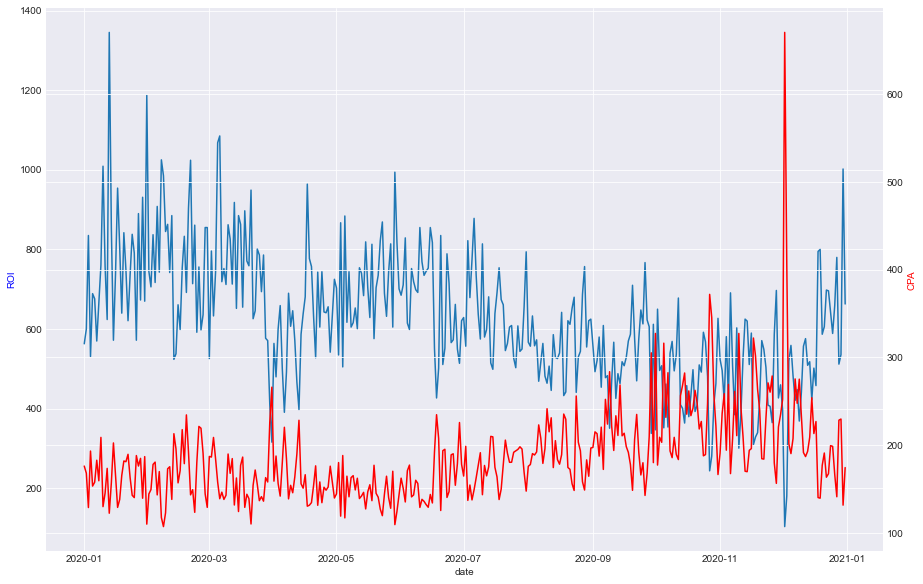

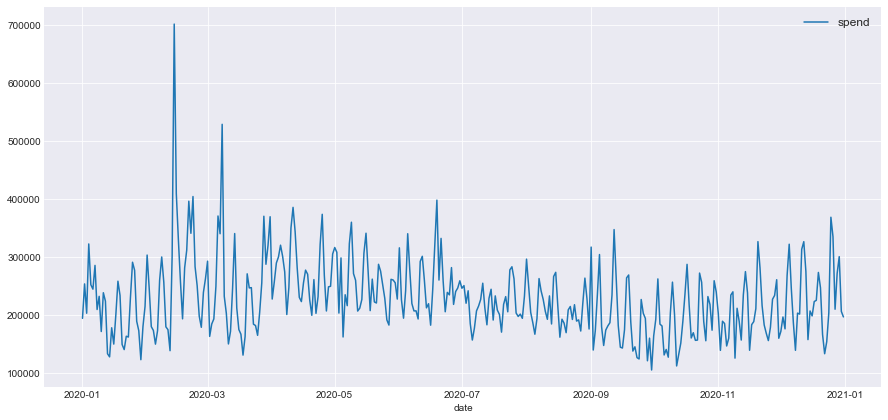

In [356]:
x = df82['date']
y1 = df82['ROI']
y2 = df82['CPA']

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.plot(x,y1, label='ROI')
ax2 = ax.twinx()
ax2.plot(x,y2, '-r', label='CPA')
ax.set_xlabel('date')
ax.set_ylabel('ROI', color = 'b')
ax2.set_ylabel(r'CPA', color = 'r')

y3 = df82['spend']
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
ax.plot(x,y3, label='spend')
ax.set_xlabel('date')
plt.legend(fontsize=12)
plt.show()

##### Мы видим постепенное падение рои до декабря, и почти противоположный график роста цены за заказ. Т.к. на протяжении года расход оставался примерно тем же самым, CPA растет из-за уменьшения числа транзакций:
Если вывести CR только для платных источников (таблица ниже), к примеру, yandex / cpc, то CR падает, а CPA соответственно растет с начала лета. 

При этом на roi также сказывается падение среднего чека (выше указали падение ARPPU, не совсем чек, но близко)

In [14]:
df3[(df3['source']=='yandex') & (df3['medium']=='cpc')]

,month,source,medium,CTR,CPA,CR
23,1,yandex,cpc,5.0,170.0,21.0
49,2,yandex,cpc,4.0,174.6,22.0
75,3,yandex,cpc,5.0,171.1,23.0
104,4,yandex,cpc,5.0,172.7,22.0
134,5,yandex,cpc,5.0,152.2,23.0
163,6,yandex,cpc,5.0,170.4,23.0
191,7,yandex,cpc,5.0,189.5,20.0
221,8,yandex,cpc,5.0,207.7,18.0
250,9,yandex,cpc,4.0,221.9,17.0
285,10,yandex,cpc,5.0,242.0,15.0


### 2. Статика по категориям

### # Источник / канал

In [4]:
sql91source ="""
SELECT source, medium,

       ROUND((SUM(revenue) / COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId))), 2) AS ARPU,
       IFNULL(ROUND(SAFE_DIVIDE(SUM(revenue), SUM(IF(transactions > 0, 1, 0))), 2),0) AS ARPPU,
       ROUND(SUM(transactions)/COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId)), 3)*100 AS CR,
       SUM(transactions) AS transactions,
       COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId)) AS users
       
  FROM `astute-asset-303615.Project_3.ga_data`

GROUP BY 1, 2
"""

df91source = pandas_gbq.read_gbq(sql91source, project_id = "astute-asset-303615")


Downloading: 100%|███████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.57rows/s]


In [220]:
df91source.sort_values('ARPU', ascending=False).head(10)

,source,medium,ARPU,ARPPU,CR,users
26,opmcpa,cpa,569.93,1151.54,50.7,691
24,DuckDuckGo,organic,481.19,1408.06,34.6,2736
6,(direct),(none),417.37,1236.05,34.1,846663
20,mytarget,organic,371.68,1364.22,27.6,4210
25,other,organic,369.56,1332.84,28.3,3603
29,bing,organic,308.18,1326.54,23.7,1937
0,google,organic,301.97,1173.72,26.2,1290635
28,sellaction,cpa,297.67,1236.29,24.3,922
4,yandex,organic,289.55,1216.38,24.3,977768
2,yandex,cpc,283.65,1318.30,21.9,1176372


#### Если отсортировать по arpu, то кроме ожидаемого organic и direct видим cpa - возможно источник cpa перетирает метки других источников

In [221]:
df91source.sort_values('ARPPU', ascending=False).head(10)

,source,medium,ARPU,ARPPU,CR,users
33,exponea,email,151.79,1760.80,8.6,58
37,baidu,organic,17.03,1567.00,1.1,92
32,other,email,127.62,1471.63,8.7,369
24,DuckDuckGo,organic,481.19,1408.06,34.6,2736
15,facebook,cpc,3.66,1366.95,0.3,34690
20,mytarget,organic,371.68,1364.22,27.6,4210
25,other,organic,369.56,1332.84,28.3,3603
29,bing,organic,308.18,1326.54,23.7,1937
19,co-promo,email,152.26,1318.42,11.7,49115
2,yandex,cpc,283.65,1318.30,21.9,1176372


#### А если по arppu, то видим, что появляются email рассылки

Text(0.5, 1.0, 'CR для топ-10 источников по посещаемости')

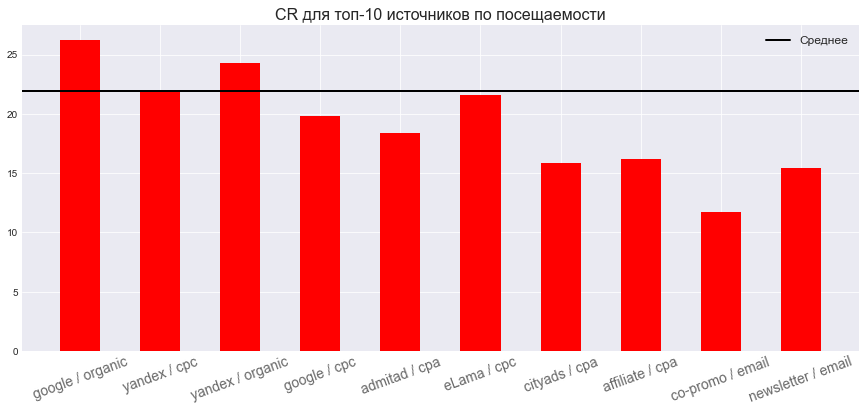

In [12]:
fig, ax = plt.subplots(figsize = (15,6))
b = df91source[df91source['source']!='(direct)'].sort_values('users', ascending=False).head(10)
x = b['source']+' '+'/'+' '+b['medium']

ax.bar(x, height= b['CR'], color = 'r', width = 0.5, label='CR' )

plt.axhline(100*sum(df91source['transactions'][df91source['source']!='(direct)'])/sum(df91source['users'][df91source['source']!='(direct)']),linewidth=2, color='k', label='Среднее')
plt.legend(["Среднее"], fontsize=12)
plt.xticks( fontsize=14, color = 'dimgrey',fontweight = 'roman', rotation=20)
ax.set_title('CR для топ-10 источников по посещаемости', fontsize=16)

#### Из платных источников, у которых есть объем, лучше всего конвертируются yandex/cpc и  eLama/cpс

### # Города

In [252]:
sql91city ="""
SELECT city,

       ROUND((SUM(revenue) / COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId))), 2) AS ARPU,
       IFNULL(ROUND(SAFE_DIVIDE(SUM(revenue), SUM(IF(transactions > 0, 1, 0))), 2),0) AS ARPPU,
       ROUND(SUM(transactions)/COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId)), 3)*100 AS CR,
       
       COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId)) AS users
       
  FROM `astute-asset-303615.Project_3.ga_data`

GROUP BY 1
"""

df91city = pandas_gbq.read_gbq(sql91city, project_id = "astute-asset-303615")

Downloading: 100%|██████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 196.47rows/s]


In [253]:
df91city.sort_values('ARPU', ascending=False).head(10)

,city,ARPU,ARPPU,CR,users
33,Щербинка,897.01,1250.43,73.2,2788
28,Сходня,657.30,1191.54,55.9,12860
23,Химки,655.06,1384.68,48.3,5386
45,Реутов,607.41,1200.16,51.0,9006
52,Октябрьский,600.39,1158.93,52.8,5760
30,Зеленоград,580.59,1231.86,47.9,20687
56,Троицк,517.14,1280.86,40.9,3522
22,Долгопрудный,507.92,1247.72,41.1,14523
29,Королев,504.94,1256.77,40.6,20305
44,Щелково,502.27,1491.08,34.4,16123


In [254]:
df91city.sort_values('ARPPU', ascending=False).head(10)

,city,ARPU,ARPPU,CR,users
44,Щелково,502.27,1491.08,34.4,16123
23,Химки,655.06,1384.68,48.3,5386
3,Москва,343.43,1373.01,25.5,2440352
50,Одинцово,444.80,1352.93,33.2,3796
46,Норильск,440.50,1283.16,35.0,12820
56,Троицк,517.14,1280.86,40.9,3522
55,Красногорск,377.20,1269.56,30.0,3322
26,Подольск,320.06,1262.46,25.6,15131
29,Королев,504.94,1256.77,40.6,20305
33,Щербинка,897.01,1250.43,73.2,2788


#### Лучше всего показатели arppu и arppu у подмосковья, возможно это связано с культурой заказа на дом, а также более высокими по сравнению с регионами ценами

Text(0.5, 1.0, 'CR для топ-10 городов')

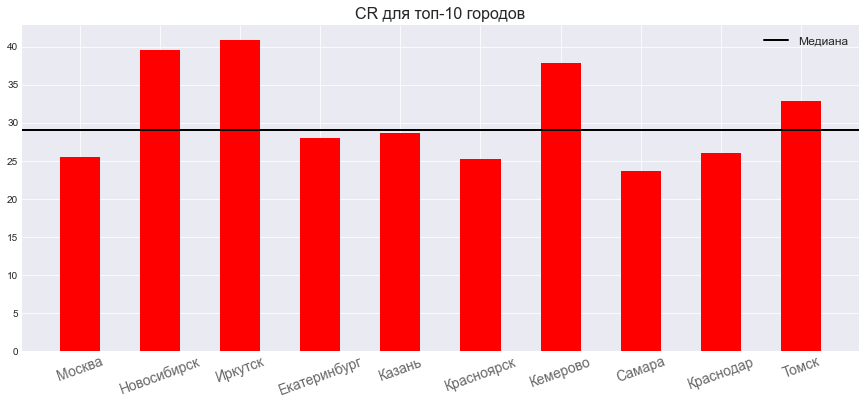

In [279]:
fig, ax = plt.subplots(figsize = (15,6))
b = df91city[df91city['city']!='Не определено'].sort_values('users', ascending=False).head(10)
x = b['city']

ax.bar(x, height= b['CR'], color = 'r', width = 0.5, label='CR' )

plt.axhline(df91city['CR'].median(),linewidth=2, color='k', label='Медиана')
plt.legend(["Медиана"], fontsize=12)
plt.xticks( fontsize=14, color = 'dimgrey',fontweight = 'roman', rotation=20)
ax.set_title('CR для топ-10 городов', fontsize=16)

#### Для регионов с более высокой конверсией можно попробовать выкупать больше трафика

### # Устройство

In [263]:
sql91device ="""
SELECT date, device_type,

       ROUND((SUM(revenue) / COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId))), 2) AS ARPU,
       IFNULL(ROUND(SAFE_DIVIDE(SUM(revenue), SUM(IF(transactions > 0, 1, 0))), 2),0) AS ARPPU,
       ROUND(SUM(transactions)/COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId)), 3)*100 AS CR,
       
       COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId)) AS users
       
  FROM `astute-asset-303615.Project_3.ga_data`
WHERE device_type!='Не определено'
GROUP BY 1, 2
"""

df91device = pandas_gbq.read_gbq(sql91device, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████████████████████████████████████████████| 732/732 [00:00<00:00, 2083.93rows/s]


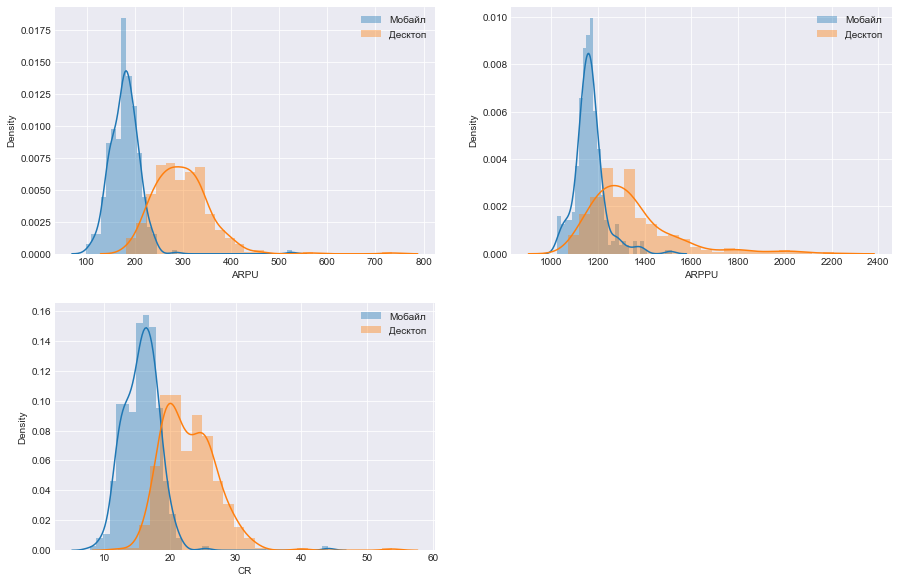

In [301]:
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
sns.distplot(df91device[df91device['device_type']=='Мобайл'].sort_values('ARPU')['ARPU'], label='Мобайл')
sns.distplot(df91device[df91device['device_type']=='Десктоп'].sort_values('ARPU')['ARPU'], label='Десктоп')
plt.legend()
plt.subplot(2, 2, 2)
sns.distplot(df91device[df91device['device_type']=='Мобайл'].sort_values('ARPPU')['ARPPU'], label='Мобайл')
sns.distplot(df91device[df91device['device_type']=='Десктоп'].sort_values('ARPPU')['ARPPU'], label='Десктоп')
plt.legend()
plt.subplot(2, 2, 3)
sns.distplot(df91device[df91device['device_type']=='Мобайл'].sort_values('CR')['CR'], label='Мобайл')
sns.distplot(df91device[df91device['device_type']=='Десктоп'].sort_values('CR')['CR'], label='Десктоп')
plt.legend()
plt.show()

#### Для ПК показатели лучше - интересно, что для ARPPU очень сильная разница в самих распределениях, а не распределения одинаковы, просто сдвинуты друг относительно друга. Возможно, если пользователи планирую сделать большой заказ, они специально используют пк, т.к. на нем удобнее

### # Использование промокода

In [14]:
sql91promo ="""
SELECT date,
       IF(promo_activated = 0, 0, 1) AS promo_activated,

       ROUND((SUM(revenue) / COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId))), 2) AS ARPU,
       IFNULL(ROUND(SAFE_DIVIDE(SUM(revenue), SUM(IF(transactions > 0, 1, 0))), 2),0) AS ARPPU,
       ROUND(SUM(transactions)/COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId)), 3)*100 AS CR,
       
       COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId)) AS users
       
  FROM `astute-asset-303615.Project_3.ga_data`

GROUP BY 1, 2
"""

df91promo = pandas_gbq.read_gbq(sql91promo, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████████████████████████████████████████████| 732/732 [00:00<00:00, 1622.49rows/s]


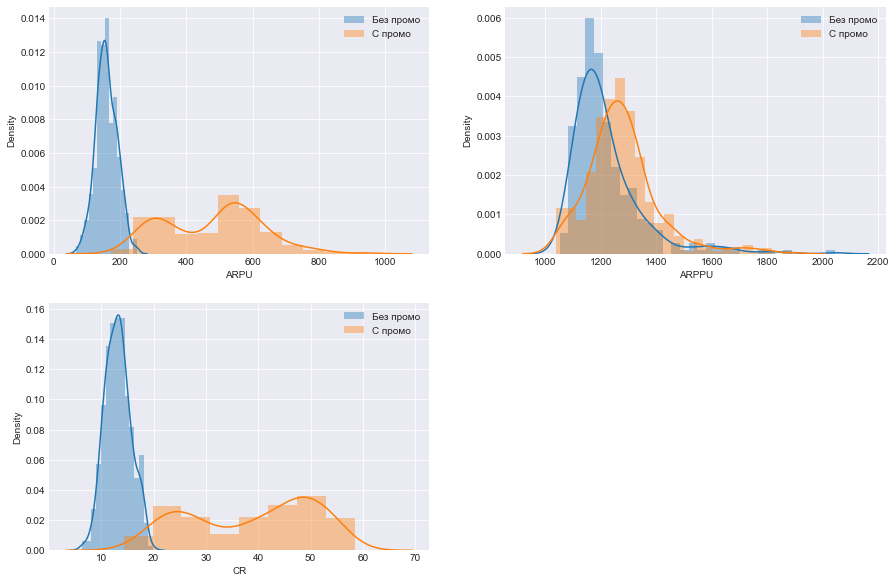

In [11]:
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
sns.distplot(df91promo[df91promo['promo_activated']==0].sort_values('ARPU')['ARPU'], label='Без промо')
sns.distplot(df91promo[df91promo['promo_activated']==1].sort_values('ARPU')['ARPU'], label='С промо')
plt.legend()
plt.subplot(2, 2, 2)
sns.distplot(df91promo[df91promo['promo_activated']==0].sort_values('ARPPU')['ARPPU'], label='Без промо')
sns.distplot(df91promo[df91promo['promo_activated']==1].sort_values('ARPPU')['ARPPU'], label='С промо')
plt.legend()
plt.subplot(2, 2, 3)
sns.distplot(df91promo[df91promo['promo_activated']==0].sort_values('CR')['CR'], label='Без промо')
sns.distplot(df91promo[df91promo['promo_activated']==1].sort_values('CR')['CR'], label='С промо')
plt.legend()
plt.show()

#### При использовании промо показатели также лучше, хотя судя по графику ARPPU среднее отличается всего на 100р

## Анализ данных

### 1. Проверить статистическую гипотезу о различии CR для пользователей:
#### - C наличием и отсутствием доставки. 

In [5]:
sql10delivery ="""
SELECT date, delivery_available,

       ROUND(SUM(transactions)/COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId)), 3)*100 AS CR,
       
  FROM `astute-asset-303615.Project_3.ga_data`
WHERE delivery_available!="Не определено"
GROUP BY 1, 2
"""

df10delivery = pandas_gbq.read_gbq(sql10delivery, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████████████████████████████████████████████| 732/732 [00:00<00:00, 1668.09rows/s]


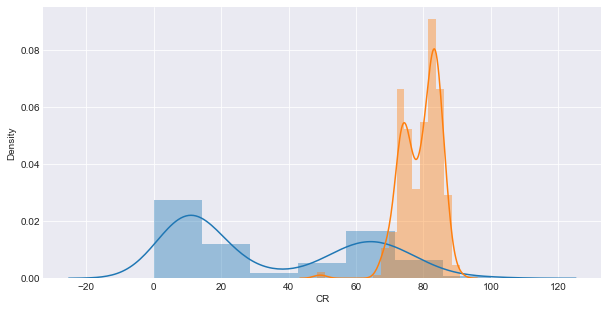

In [6]:
plt.figure(figsize = (10, 5))
sns.distplot(df10delivery[df10delivery['delivery_available']=='Доставки нет'].sort_values('CR')['CR'] )
sns.distplot(df10delivery[df10delivery['delivery_available']=='Доставка есть'].sort_values('CR')['CR'] )
plt.show()

In [7]:
delivery = df10delivery[df10delivery['delivery_available']=='Доставки нет']['CR']
not_delivery = df10delivery[df10delivery['delivery_available']=='Доставка есть']['CR']
mannwhitneyu(x=delivery, y=not_delivery)

MannwhitneyuResult(statistic=5978.5, pvalue=3.345167723883924e-101)

Т.к. p-value < 0,05 мы отвергаем нулевую гипотезу об отсутствии различий средних значений CR

#### - Из Москвы и регионов.

In [13]:
sql10city ="""
SELECT date, city,
       ROUND(SUM(transactions)/COUNT(DISTINCT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId)), 3)*100 AS CR,
       
  FROM `astute-asset-303615.Project_3.ga_data`

GROUP BY 1, 2
"""

df10city = pandas_gbq.read_gbq(sql10city, project_id = "astute-asset-303615")

Downloading: 100%|██████████████████████████████████████████████████████████| 19462/19462 [00:01<00:00, 10222.54rows/s]


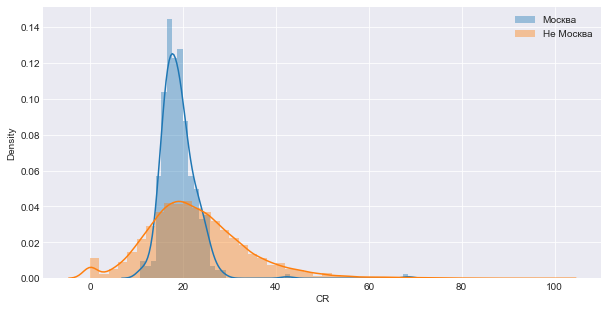

In [14]:
plt.figure(figsize = (10, 5))
sns.distplot(df10city[df10city['city']=='Москва'].sort_values('CR')['CR'], label='Москва' )
sns.distplot(df10city[df10city['city']!='Москва'].sort_values('CR')['CR'], label='Не Москва' )
plt.legend()
plt.show()

In [15]:
moscow = df10city[df10city['city']=='Москва']['CR']
not_moscow = df10city[df10city['city']!='Москва']['CR']
print(stats.shapiro(moscow), '\n', 
      stats.shapiro(not_moscow))

ShapiroResult(statistic=0.7274160385131836, pvalue=4.885202988019769e-24) 
 ShapiroResult(statistic=0.9580219984054565, pvalue=0.0)


На графике синее распреденение смахивает на нормальное, но тест так не показывает, поэтому также используем непараметрический метод далее

In [20]:
mannwhitneyu(x=moscow, y=not_moscow)

MannwhitneyuResult(statistic=2721788.0, pvalue=1.959662983559137e-13)

Т.к. p-value < 0,05 мы отвергаем нулевую гипотезу об отсутствии различий средних значений CR

#### - С активацией промокода и без.

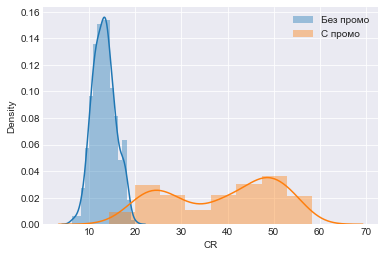

In [17]:
sns.distplot(df91promo[df91promo['promo_activated']==0].sort_values('CR')['CR'], label='Без промо')
sns.distplot(df91promo[df91promo['promo_activated']==1].sort_values('CR')['CR'], label='С промо')
plt.legend()
plt.show()

In [21]:
promo_used = df91promo[df91promo['promo_activated']==1]['CR']
promo_not_used = df91promo[df91promo['promo_activated']==0]['CR']
print(stats.shapiro(promo_used), '\n', 
      stats.shapiro(promo_not_used))

ShapiroResult(statistic=0.9263514280319214, pvalue=1.9200771615018875e-12) 
 ShapiroResult(statistic=0.9933239221572876, pvalue=0.10491917282342911)


In [23]:
mannwhitneyu(x=promo_used, y=promo_not_used)

MannwhitneyuResult(statistic=337.0, pvalue=2.367577898633462e-120)

Тут также тест показывает, что мы принимаем альтернативную гипотезу о неравенстве средних, зато тест на нормальность для распределений на графике показал, что для синего распреденения мы отвергнуть гипотезу о нормальности распределения не можем, т.к. p-value=0,1

### 2. Спрогнозировать количество транзакций на следующий месяц (январь 2021) в детализации по дням

In [6]:
sql11 ="""
SELECT date, SUM(transactions) AS transactions,
       
  FROM `astute-asset-303615.Project_3.ga_data`

GROUP BY 1
ORDER BY 1
"""

df11 = pandas_gbq.read_gbq(sql11, project_id = "astute-asset-303615")

Downloading: 100%|███████████████████████████████████████████████████████████████| 366/366 [00:00<00:00, 1177.27rows/s]


В качестве модели используем seasonal ARIMA

Test MAE: 326.836
Test RMSE: 468.012


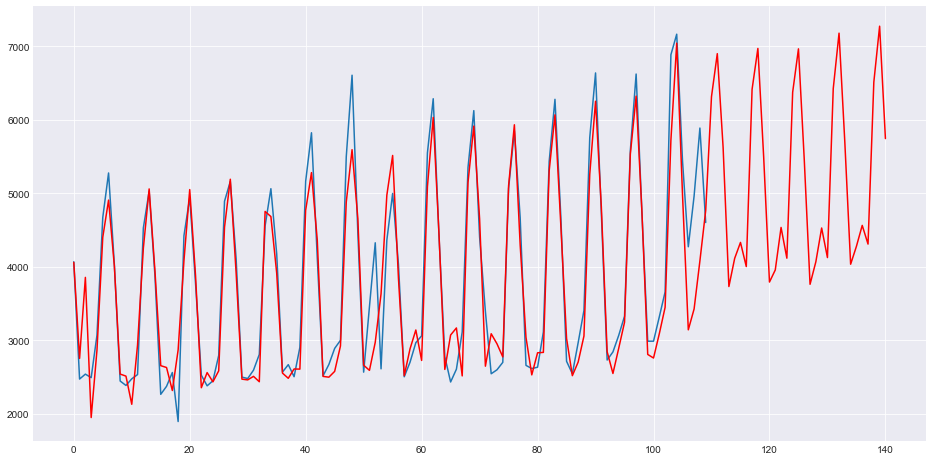

In [144]:
X = df11['transactions'].values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)+31): 
    model = sm.tsa.statespace.SARIMAX(history, order=(5,1,1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    
    if t<len(test): 
        obs = test[t]
        history.append(obs)
    else:
        history.append(yhat)

errora = mean_absolute_error(test, predictions[0:len(test)])  
print('Test MAE: %.3f' % errora) 
errors = mean_squared_error(test, predictions[0:len(test)], squared=False)  
print('Test RMSE: %.3f' % errors) 
plt.figure(figsize = (16, 8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Во время работы для модели не рассматривалась кроссвалидация, а также не рассматривались альтернативные модели. 

Данный датасет сейчас недоступен, поэтому исправить это не представляется возможным

In [101]:
print("Прогноз продаж на январь 2021:\n")
for i in range(31):
    print(i+1, round(predictions[len(test)+i],0))

Прогноз продаж на январь 2021:

1 6288.0
2 6589.0
3 4996.0
4 3726.0
5 3935.0
6 4163.0
7 4178.0
8 6300.0
9 6666.0
10 5450.0
11 4145.0
12 4385.0
13 4764.0
14 4233.0
15 6190.0
16 6513.0
17 5213.0
18 3896.0
19 4032.0
20 4284.0
21 4281.0
22 6202.0
23 6549.0
24 5245.0
25 3904.0
26 4146.0
27 4411.0
28 4336.0
29 6199.0
30 6484.0
31 5340.0


### 3. Построить модель: 
####  Классифицирующую пользователей на тех, кто совершит транзакцию и нет


In [18]:
sql12 ="""
SELECT IF(clientId LIKE 'GA%', SUBSTR(clientId, 7), clientId) AS clientId,
       SUM(transactions) AS transactions,
       SUM(revenue) AS revenue,
       SUM(filter_used) AS filter_used,
       SUM(promo_activated) AS promo_activated,
       SUM(pageviews) AS pageviews,
       SUM(visits) AS visits,
       SUM(productClick) AS productClick,
       SUM(addToCart) AS addToCart,
       SUM(checkout) AS checkout,
       STRING_AGG(device_type) AS device_type,
       CAST(CEIL(RAND()*100) as int64) random
       
  FROM `astute-asset-303615.Project_3.ga_data`
  WHERE device_type!='Не определено' 
GROUP BY 1
-- Разрядим данные чтобы не убить ноутбук
HAVING MOD(random,10)=7
"""

df12 = pandas_gbq.read_gbq(sql12, project_id = "astute-asset-303615")


Downloading: 100%|█████████████████████████████████████████████████████████| 476662/476662 [01:25<00:00, 5558.89rows/s]


#### Предобработка данных 

In [22]:
df12 = df12.drop('clientId', axis = 1).drop('random', axis = 1)

In [23]:
df12['isTransaction'] = df12['transactions'].apply(lambda x: 1 if x>0 else 0)

In [24]:
def device_type(value):
    if 'Мобайл' not in value:
        return 'Десктоп'
    elif 'Десктоп' not in value:
        return 'Мобайл'
    else: 
        return 'Кросс'

df12['device_type'] = df12['device_type'].apply(device_type)

In [25]:
df12

,transactions,revenue,filter_used,promo_activated,pageviews,visits,productClick,addToCart,checkout,device_type,isTransaction
0,0,0.0,0,2,37,3,40,8,10,Мобайл,0
1,3,3695.0,0,2,33,4,120,24,17,Кросс,1
2,3,3769.0,0,8,30,5,110,22,18,Десктоп,1
3,3,2214.0,0,0,53,3,90,18,19,Мобайл,1
4,1,1310.0,0,1,38,2,30,6,5,Мобайл,1
...,...,...,...,...,...,...,...,...,...,...,...
476657,1,827.0,0,0,22,1,60,12,4,Мобайл,1
476658,1,1286.0,0,1,22,2,50,10,11,Мобайл,1
476659,1,703.0,1,5,22,3,40,8,6,Десктоп,1
476660,1,1182.0,0,4,22,1,30,6,3,Десктоп,1


In [26]:
corr = df12.corr()
corr

,transactions,revenue,filter_used,promo_activated,pageviews,visits,productClick,addToCart,checkout,isTransaction
transactions,1.000000,0.872813,0.158096,0.414594,0.631693,0.502701,0.674531,0.673453,0.734905,0.630030
revenue,0.872813,1.000000,0.147272,0.370874,0.578106,0.427401,0.684689,0.683658,0.651579,0.625147
filter_used,0.158096,0.147272,1.000000,0.148142,0.206849,0.158770,0.198809,0.198773,0.170451,0.077664
promo_activated,0.414594,0.370874,0.148142,1.000000,0.660471,0.552086,0.525453,0.525381,0.510758,0.247303
pageviews,0.631693,0.578106,0.206849,0.660471,1.000000,0.634735,0.729156,0.729333,0.776847,0.414928
visits,0.502701,0.427401,0.158770,0.552086,0.634735,1.000000,0.483818,0.483558,0.493991,0.223117
productClick,0.674531,0.684689,0.198809,0.525453,0.729156,0.483818,1.000000,0.999697,0.697251,0.423406
addToCart,0.673453,0.683658,0.198773,0.525381,0.729333,0.483558,0.999697,1.000000,0.696830,0.422765
checkout,0.734905,0.651579,0.170451,0.510758,0.776847,0.493991,0.697251,0.696830,1.000000,0.491914
isTransaction,0.630030,0.625147,0.077664,0.247303,0.414928,0.223117,0.423406,0.422765,0.491914,1.000000


In [27]:
# изменяем категориальные признаки
encoder1 = OrdinalEncoder()
X1 = df12.drop('revenue', axis = 1).drop('transactions', axis = 1).drop('isTransaction', axis = 1)
X1['device_type'] = encoder1.fit_transform(X1[['device_type']])

y1 = df12['isTransaction']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state = 1, test_size = 0.2)

#### Строим модель логистической регрессии

In [135]:
logreg = LogisticRegression(random_state = 1)
logreg.fit(X1_train, y1_train)
logreg_pred  = logreg.predict(X1_test)
cv = cross_validate(logreg, X1, y1, cv = 5, scoring = 'roc_auc')
cv1 = cross_validate(logreg, X1, y1, cv = 5, scoring = 'f1')

print('Результат логистической регрессии:')
print("f1_score:", f1_score(logreg_pred, y1_test))
print("roc_auc:", roc_auc_score(logreg_pred, y1_test))
print('\nКросс-валидация:\n')
print("Средний f1:", cv1['test_score'].mean())
print("Средний roc_auc:", cv['test_score'].mean())

Результат логистической регрессии:
f1_score: 0.6222539507414739
roc_auc: 0.8273755450380124

Кросс-валидация:

Средний f1: 0.5267014002327477
Средний roc_auc: 0.9597326147995604


#### Попробуем учесть несбалансированность классов и посмотреть, станет ли лучше

In [111]:
sum(df12['isTransaction'])

90757

In [20]:
# итого классов 90к : 400к, один к четырем

In [145]:
logreg = LogisticRegression(random_state = 1, class_weight={0:0.2, 1:0.8})
logreg.fit(X1_train, y1_train)
logreg_pred  = logreg.predict(X1_test)
cv = cross_validate(logreg, X1, y1, cv = 5, scoring = 'roc_auc')
cv1 = cross_validate(logreg, X1, y1, cv = 5, scoring = 'f1')

print('Результат логистической регрессии:')
print("f1_score:", f1_score(logreg_pred, y1_test))
print("roc_auc:", roc_auc_score(logreg_pred, y1_test))
print('\nКросс-валидация:\n')
print("Средний f1:", cv1['test_score'].mean())
print("Средний roc_auc:", cv['test_score'].mean())

Результат логистической регрессии:
f1_score: 0.7874050370080857
roc_auc: 0.8398755014914736

Кросс-валидация:

Средний f1: 0.7530815227939838
Средний roc_auc: 0.962415672438951


#### Строим random forest

In [137]:
forestclass = RandomForestClassifier(random_state = 1)
forestclass.fit(X1_train, y1_train)
forestclass_pred = forestclass.predict(X1_test)
cv = cross_validate(forestclass, X1, y1, cv = 5, scoring = 'roc_auc')
cv1 = cross_validate(forestclass, X1, y1, cv = 5, scoring = 'f1')

print("Результаты случайного леса:")
print("f1_score:", f1_score(forestclass_pred, y1_test))
print("roc_auc:", roc_auc_score(forestclass_pred, y1_test))
print('\nКросс-валидация:\n')
print("Средний f1:", cv1['test_score'].mean())
print("Средний roc_auc:", cv['test_score'].mean())

Результаты случайного леса:
f1_score: 0.8146681410239925
roc_auc: 0.8667547251650255

Кросс-валидация:

Средний f1: 0.4212603906945656
Средний roc_auc: 0.617671917737392


#### Результаты для случайного леса на тренировочной выборке лучше, однако на кроссвалидации плохие, скорее всего это связано с наличием временного тренда в данных